In [36]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
from pathlib import Path, PureWindowsPath

In [37]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list

In [38]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()

In [39]:
def get_tiny_image(img, output_size):
    h, w = np.shape(img)
    new_w, new_h = output_size
    num_w = int(w/new_w)
    num_h = int(h/new_h)
    # edge cases for if the new sizes are not a factor of the initial sizes
    extra_w = w%new_w
    extra_h = h%new_h
    
    feature = np.zeros((new_h, new_w))
    plt.imshow(feature)
    
    # tracking intensity and pixels to average them out later
    tot_tot_intensity = 0
    tot_counter = 0
    x_pos = 0
    y_pos = 0
    
    # iterating across new tiny image
    for i in range(new_w):
        y_pos = 0
        for j in range(new_h):
            counter = 0
            tot_intensity = 0
            
            # seeing if extra pixels need to be factored in
            if i < extra_w-1:
                w_range = num_w+1
            else:
                w_range = num_w
            if j < extra_h-1:
                h_range = num_h+1
            else:
                h_range = num_h
                
            # iterating across corresponding sections of original image
            for m in range(x_pos, x_pos+w_range):
                for n in range(y_pos, y_pos+h_range):
                    counter += 1
                    tot_intensity += img[n, m]
                    tot_counter += 1
                    tot_tot_intensity += img[n, m]
            average = tot_intensity/counter
            feature[j, i] = average
            y_pos += h_range
        x_pos += w_range

    # getting mean of image to normalize and normalizing
    true_mean = tot_tot_intensity/tot_counter
    norm = 0
    for i in range(new_w):
        for j in range(new_h):
            feature[j,i] -= true_mean
            norm += feature[j,i]**2
    norm = math.sqrt(norm)
    for i in range(new_h):
        for j in range(new_h):
            feature[j,i] = feature[j,i]/norm

    return feature

In [40]:
def predict_knn(feature_train, label_train, feature_test, k):
    nbrs = KNeighborsClassifier(n_neighbors=k, algorithm='auto')\
    .fit(feature_train, label_train)

    label_test_pred = nbrs.predict(feature_test)
    
    return label_test_pred


In [41]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    
    feature_train = []
    feature_test = []

    # iterating through img train list and getting tiny image features
    for x in img_train_list:
        img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        new_img = get_tiny_image(img, (16,16))
        flattened = np.ndarray.flatten(new_img)
        feature_train.append(flattened)

    # iterating through test list and getting tiny image features
    for x in img_test_list:
        img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        new_img = get_tiny_image(img, (16,16))
        flattened = np.ndarray.flatten(new_img)
        feature_test.append(flattened)
    
    label_test_pred = predict_knn(feature_train, label_train_list, feature_test, 5)
    confusion = confusion_matrix(label_test_list, label_test_pred)
    accuracy = accuracy_score(label_test_list, label_test_pred)
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy


In [42]:
label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info('./scene_classification_data')

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


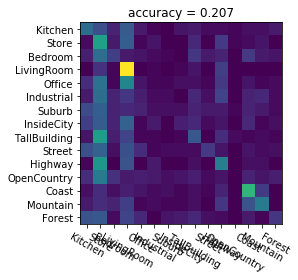

In [43]:
confusion, accuracy = classify_knn_tiny(label_classes, label_train_list, \
                                       img_train_list, label_test_list, \
                                       img_test_list)


In [44]:
def compute_dsift(img, stride, size):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints = []
    h, w = np.shape(img)
    x = stride
    y = stride
    dense_feature = []
    
    # iterate through image and store keypoints
    while x < w:
        y = stride
        while y < h:
            keypoints.append(cv2.KeyPoint(x, y, size))
            y += stride
        x += stride
    
    dense_feature = sift.compute(img, keypoints)[1]
        
    return dense_feature

In [45]:
def build_visual_dictionary(dense_feature_list, dic_size):
    kmeans = KMeans(n_clusters=dic_size, n_init=10, max_iter=20).fit(dense_feature_list)
    vocab = kmeans.cluster_centers_
    return vocab

In [46]:
def compute_bow(feature, vocab):
    bow_feature = np.zeros((np.shape(vocab)[0]))
    nbrs = NearestNeighbors(n_neighbors=1).fit(vocab)
    
    for i in feature:
        distances, indices = nbrs.kneighbors(i.reshape(1,-1))
        bow_feature[indices] += 1

    # normalizing bow_feature
    bow_feature = bow_feature/np.linalg.norm(bow_feature)

    return bow_feature

In [47]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    
    dense_feature_list = []

    # extracting pool of all features
    for x in img_train_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        dense_feature = compute_dsift(temp_img, 16, 16)
        for i in dense_feature:
            dense_feature_list.append(i)
            
    # building visual dictionary
    centers = build_visual_dictionary(dense_feature_list, 100)
    np.savetxt('16x16centers_2.1_knn15_100dic_final.txt', centers)
    
#     centers = np.loadtxt('16x16centers_2.1_knn15_100dic_final.txt')
    
    feature_train = []
    feature_test = []
    
    # getting list of BoW histograms for training set
    for x in img_train_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        feature = compute_dsift(temp_img, 16, 16)
        bow = compute_bow(feature, centers)
        feature_train.append(bow)
    feature_train = np.array(feature_train)

    # getting list of BoW histograms for test set
    for x in img_test_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        feature = compute_dsift(temp_img, 16, 16)
        bow = compute_bow(feature, centers)
        feature_test.append(bow)
    feature_test = np.array(feature_test)

    label_test_pred = predict_knn(feature_train, label_train_list, feature_test, 15)
    confusion = confusion_matrix(label_test_list, label_test_pred)
    accuracy = accuracy_score(label_test_list, label_test_pred)
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

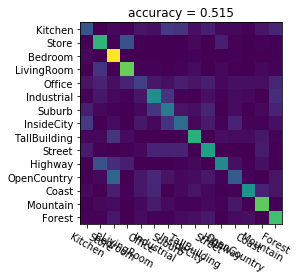

In [48]:
confusion, accuracy = classify_knn_bow(label_classes, label_train_list, \
                                       img_train_list, label_test_list, \
                                       img_test_list)

In [49]:
def predict_svm(feature_train, label_train, feature_test): 
    
    # switching all the labels to binary,
    # labels is list of 15 binary labelled sets
    labels = []
    
    for i in range(np.shape(label_classes)[0]):
        target_string = label_classes[i]
        binary_label = []
        for j in range(np.shape(label_train)[0]):
            if label_train[j] == target_string:
                binary_label.append(True)
            else:
                binary_label.append(False)
        labels.append(binary_label)
        
        
    # training 15 classifiers
    classifiers = []
    for i in range(np.shape(label_classes)[0]):
        new_classifier = LinearSVC(C=1, max_iter=5000, tol=1e-3)
        new_classifier.fit(feature_train, labels[i])
        classifiers.append(new_classifier)

    # getting best prediction out of 15 classifiers for each test sample
    label_test_pred = []
    for i in range(np.shape(feature_test)[0]):
        predictions = []
        for j in range(np.shape(classifiers)[0]):
            confidence = classifiers[j].decision_function(feature_test[i].reshape(1,-1))
            predictions.append(confidence)
        label_test_pred.append(label_classes[np.argmax(predictions)])
            
    label_test_pred = np.array(label_test_pred)
    return label_test_pred

In [50]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    dense_feature_list = []

    # extracting pool of all features
    for x in img_train_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        dense_feature = compute_dsift(temp_img, 16, 16)
        for i in dense_feature:
            dense_feature_list.append(i)
            
    # building visual dictionary
    centers = build_visual_dictionary(dense_feature_list, 100)
    np.savetxt('16x16centers_2.1_knn15_100dic_final.txt', centers)
    
#     centers = np.loadtxt('16x16centers_2.1_knn15_100dic_final.txt')
    
    feature_train = []
    feature_test = []
    
    # getting list of BoW histograms for training set
    for x in img_train_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        feature = compute_dsift(temp_img, 16, 16)
        bow = compute_bow(feature, centers)
        feature_train.append(bow)
    feature_train = np.array(feature_train)

    # getting list of BoW histograms for test set
    for x in img_test_list:
        temp_img = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
        feature = compute_dsift(temp_img, 16, 16)
        bow = compute_bow(feature, centers)
        feature_test.append(bow)
    feature_test = np.array(feature_test)
    
    label_test_pred = predict_svm(feature_train, label_train_list, feature_test)
    confusion = confusion_matrix(label_test_list, label_test_pred)
    accuracy = accuracy_score(label_test_list, label_test_pred)
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

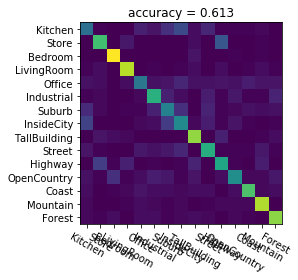

In [51]:
confusion, accuracy = classify_svm_bow(label_classes, label_train_list, \
                                       img_train_list, label_test_list, \
                                       img_test_list)